In [1]:
import torch
from torch import nn
from IPython import display
## lead helper functions from d2l
import sys
sys.path.insert(0, 'C:\\Users\\Shiwen\\dl_practice_pytorch\\function')
import d2l_torch as d2l

In [2]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

**Structure**
- two convolution layers with (1) 6 and 16 output channels, (2) 5x5 kernel, (3) padding (5-1)/2 = 2 and 0, (4) sigmoid activation functions
  - followed by average pooling with (1) 2x2 kernel , (2) stride 2
- three fully connected layers with sigmoid activation function: 16x5x5 -> 120 -> 84 -> 10

In [3]:
## test result: with ReLu (replace Sigmoid), the test accuracy is ~86%
## test results: with higher channels (6, 16) -> (16, 32), the test accuracy is ~83%
## test results: with higher channels (6, 16) -> (16, 32) and ReLU, the test accuracy is ~87%
## conclusion: ReLu significantly improves the test accuracy
net = torch.nn.Sequential(
    Reshape(),
#     nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 1x28x28 -> 6x28x28
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), # 1x28x28 -> 6x28x28
    nn.AvgPool2d(kernel_size=2, stride=2), # 6x28x28 -> 6x14x14
#     nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), # 6x14x14 -> 16x10x10
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), # 6x14x14 -> 16x10x10
    nn.AvgPool2d(kernel_size=2, stride=2), # 16x10x10 -> 16x5x5
    nn.Flatten(), # 16x5x5 -> 1x400
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), # 1x400 > 1x120
    nn.Linear(120, 84), nn.Sigmoid(), # 1x120 -> 1x84
    nn.Linear(84, 10)) # 1x84 -> 1x10

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


**Load Fashion MNIST data**

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [6]:
# evaluate_accuracy_gpu function depend on 
# (1) accuracy() function
# (2) Accumulator class in d2l
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2);
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
# train_gpu depends on 
# (1) d2l.Animator function
# (2) d2l.Timer class
# (3) d2l.accuracy function
# (4) evaluate_accuracy_gpu function
def train_gpu(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on ', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # pause updating the gradient while calculating evaluation metrics
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter) # no device -> cpu
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.310, train acc 0.885, test acc 0.855
69360.1 examples/sec on cuda:0


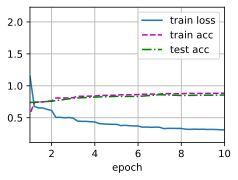

In [8]:
lr, num_epochs = 0.9, 10
train_gpu(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())